## **Data Science - Single Cell RNA sequencing analysis worksheet**

**Initial set up steps**

**1. Change Runtime type to T4 GPU**

**2. Mount your google drive to this google Co-lab session**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import json
import requests
import pandas as pd

# API request for that gene to panelapp
# create dataframe of gene, panel_name, expert review, last updated

server = "https://panelapp.genomicsengland.co.uk/api/v1"
content_headers = {"Content-Type": "application/json"}

def query_panelapp(gene):
    ext = "/genes/" + gene
    r = requests.get(server+ext, headers=content_headers, timeout=120)
    result_panelapp = r.json()
    df = pd.json_normalize(result_panelapp["results"])
    gene_dataframe = df[["entity_name","panel.name","panel.version","panel.version_created","evidence"]]
    return gene_dataframe


full_df = pd.DataFrame(columns=["entity_name","panel.name","panel.version","panel.version_created","evidence"])
genes_of_interest = ["MYO9B", "VAMP2"]

for gene in genes_of_interest:
    output_df = query_panelapp(gene)
    full_df = pd.concat([full_df,output_df], ignore_index=True)


print(full_df)


   entity_name                                         panel.name  \
0        MYO9B      Gastrointestinal epithelial barrier disorders   
1        MYO9B                                             Autism   
2        MYO9B                              Hereditary neuropathy   
3        MYO9B             Hereditary neuropathy or pain disorder   
4        VAMP2        Paroxysmal central nervous system disorders   
5        VAMP2                                              DDG2P   
6        VAMP2                  Early onset or syndromic epilepsy   
7        VAMP2                            Intellectual disability   
8        VAMP2  Adult onset dystonia, chorea or related moveme...   
9        VAMP2  Childhood onset dystonia, chorea or related mo...   
10       VAMP2       Research panel - Severe Paediatric Disorders   

   panel.version        panel.version_created  \
0           1.75  2024-04-02T14:17:05.871791Z   
1           0.36  2023-08-24T11:18:56.826577Z   
2          1.497  2025-0

**3. Place the downloaded data 'Hufallopiantube.h5ad' into your google drive**
* You can drag and drop this from your downloads file, into the Files file icon on the left, and navigating to 'drive/MyDrive'


**4. Install additional required packages**

In [ ]:
!pip install 'scanpy[leiden]'


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 59.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 46.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 3.4 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1


**5. Import required packages**

In [ ]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# **1. AnnData as a data object** anndata.svg


We will explore a small single cell RNA sequencing dataset of Fallopian Tube cells. The dataset includes benign samples from 5 patients , and high grade serous ovarian carcinoma (HGOC) samples from 5 patients.

High-grade serous ovarian cancer (HGOC) is the most common and aggressive type of epithelial ovarian cancer.

It is hypothesised to originate from Serous tubal intraepithelial carcinoma (STIC) cells in the fallopian tube.


**1. Read in data to create an Anndata object**


In [ ]:
hu = sc.read_h5ad('Hufallopiantube.h5ad')

In [ ]:
unfiltered = sc.read_h5ad('Hufallopiantube.h5ad')

**2. View the structure of the data**

In [ ]:
hu

AnnData object with n_obs × n_vars = 4557 × 22109
    obs: 'Patient', 'Author', 'Tissue', 'Disease_stage', 'Age'

In [ ]:
df_unfiltered = unfiltered.to_df()
df_unfiltered_small = df_unfiltered[["KRT17", "CLU", "PTPRC", "HMGA1", "ACTB"]]
df_unfiltered_small.describe()

Gene          KRT17           CLU        PTPRC        HMGA1           ACTB
count   4557.000000   4557.000000  4557.000000  4557.000000    4557.000000
mean     831.622559   9067.464121    21.016678   131.194865    7060.152513
std     2645.893847   9954.159706   270.200773   332.221178    9161.719226
min        0.000000      0.000000     0.000000     0.000000       0.000000
25%        0.000000   2225.000000     0.000000     0.000000    1441.000000
50%        0.000000   5735.000000     0.000000     2.000000    4167.000000
75%      212.000000  12692.000000     0.000000    98.000000    9121.000000
max    42958.000000  79595.000000  7778.000000  4513.000000  104015.000000

In [ ]:
df = hu.to_df()
df_small = df[["KRT17", "CLU", "PTPRC", "HMGA1", "ACTB"]]
df_small.describe()


Gene          KRT17           CLU        PTPRC        HMGA1          ACTB
count   4230.000000   4230.000000  4230.000000  4230.000000   4230.000000
mean     654.799054   9085.594326    20.688889   100.494799   5992.353664
std     2253.720531   9862.471133   254.255754   271.606383   7205.533902
min        0.000000      0.000000     0.000000     0.000000      0.000000
25%        0.000000   2336.500000     0.000000     0.000000   1312.500000
50%        0.000000   5774.000000     0.000000     0.000000   3692.000000
75%       87.750000  12641.500000     0.000000    75.750000   8136.250000
max    37861.000000  79595.000000  7778.000000  2861.000000  82326.000000

In [ ]:
hu.var

Empty DataFrame
Columns: []
Index: [WASH7P, LOC729737, LOC100133331, LOC100288069, LINC00115, LOC643837, FAM41C, LOC100130417, SAMD11, NOC2L, KLHL17, PLEKHN1, C1orf170, HES4, ISG15, AGRN, RNF223, C1orf159, LOC254099, MIR200B, MIR200A, MIR429, TTLL10, TNFRSF18, TNFRSF4, SDF4, B3GALT6, FAM132A, UBE2J2, SCNN1D, ACAP3, PUSL1, CPSF3L, GLTPD1, TAS1R3, DVL1, MXRA8, AURKAIP1, CCNL2, LOC148413, MRPL20, ANKRD65, TMEM88B, VWA1, ATAD3C, ATAD3B, ATAD3A, TMEM240, SSU72, C1orf233, MIB2, MMP23B, MMP23A, CDK11B, SLC35E2B, CDK11A, SLC35E2, NADK, GNB1, CALML6, TMEM52, KIAA1751, GABRD, PRKCZ, C1orf86, SKI, MORN1, LOC100129534, RER1, PEX10, PLCH2, PANK4, HES5, LOC115110, LOC100133445, TNFRSF14, FAM213B, MMEL1, TTC34, ACTRT2, FLJ42875, PRDM16, ARHGEF16, MEGF6, MIR551A, TPRG1L, WRAP73, TP73, TP73-AS1, CCDC27, SMIM1, LRRC47, CEP104, DFFB, C1orf174, LOC100133612, AJAP1, NPHP4, KCNAB2, CHD5, ...]

[22109 rows x 0 columns]

**3. View the meta data**

In [ ]:
hu.obs

Patient   Author                       Tissue Disease_stage Age
CellID                                                                       
sc_b1_A08       33572  Hu_2020  Benign fallopian tube cells        Benign  64
sc_b1_B06       34350  Hu_2020  Benign fallopian tube cells        Benign  50
sc_b1_B08       34350  Hu_2020  Benign fallopian tube cells        Benign  50
sc_b1_B11       34350  Hu_2020  Benign fallopian tube cells        Benign  50
sc_b1_C15       34350  Hu_2020  Benign fallopian tube cells        Benign  50
...               ...      ...                          ...           ...  ..
15072R-p1-B17   15072  Hu_2020   HGSOC fallopian tube cells         IIIc1  62
15072R-p1-B18   15072  Hu_2020   HGSOC fallopian tube cells         IIIc1  62
15072R-p1-C01   15072  Hu_2020   HGSOC fallopian tube cells         IIIc1  62
15072R-p1-C02   15072  Hu_2020   HGSOC fallopian tube cells         IIIc1  62
15072R-p1-C03   15072  Hu_2020   HGSOC fallopian tube cells         IIIc1  62

[4557 rows x 5 columns]

**4. View the highest expressed genes**

  Using sc.pl.highest_expr_genes(data, n_top=int)

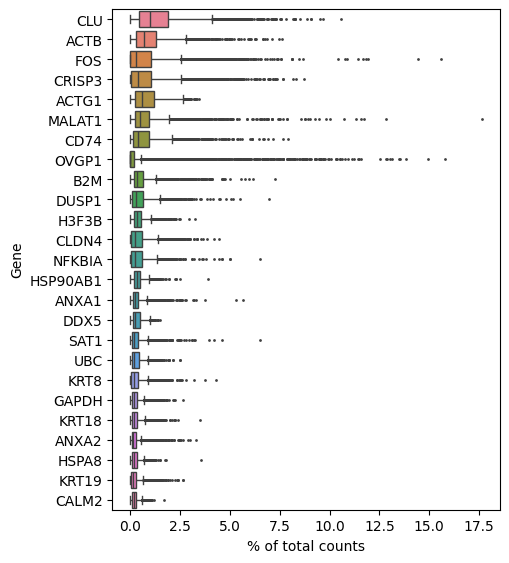

In [ ]:
sc.pl.highest_expr_genes(hu, n_top=25)

# **2. Filtering of the data**


**1. Filter out cells which have less than 100 genes expressed, and genes which are expressed in less than 3 cells.**

Use the scanpy commands:

* sc.pp.filter_cells(data, min_genes= *int*)
* sc.pp.filter_genes(data, min_cells= *int*)



In [ ]:
sc.pp.filter_cells(hu, min_genes=100)

In [ ]:
sc.pp.filter_genes(hu, min_cells=3)

**2.Calculate quality control metrics**

* sc.pp.calculate_qc_metrics(data, percent_top=(50/
100/200/500),inplace=True, log1p=False, )

In [ ]:
sc.pp.calculate_qc_metrics(hu,inplace=True, log1p=False, )

In [ ]:
sc.pp.calculate_qc_metrics(unfiltered,inplace=True, log1p=False, )

**3. View quality control metrics in a violin plot**
* sc.pl.violin(data, ['n_genes_by_counts','total_counts'],jitter=0.4, multi_panel=True)

In [ ]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

ncols = 2
nrows = 2
figsize = 4
wspace = 0.5
fig, axs = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(ncols * figsize + figsize * wspace * (ncols - 1), nrows * figsize),
)


fig.suptitle("Counts pre and post filtering", fontsize=16)

axs[0,0].title.set_text('Unfiltered - Genes detected per cell')
axs[0,0].set_ylim([0,8000])
axs[1,0].title.set_text('Unfiltered - Counts per cell')
axs[1,0].set_ylim([0,3500000])
axs[0,1].title.set_text('Filtered - Genes detected per cell')
axs[0,1].set_ylim([0,8000])
axs[1,1].title.set_text('Filtered - Counts per cell')
axs[1,1].set_ylim([0,3500000])


plt.subplots_adjust(wspace=wspace)

sc.pl.violin(unfiltered,['n_genes_by_counts'], inner="box", show = False, ax=axs[0,0], ylabel= "count", color="#ff9966", stripplot=False)
sc.pl.violin(unfiltered,['total_counts'], inner="box", show = False, ax=axs[1,0], ylabel= "count", color="#ff9966", stripplot=False)
sc.pl.violin(hu,['n_genes_by_counts'], inner="box",  show = False, ax=axs[0,1], ylabel= "count", color="#6666ff", stripplot=False)
sc.pl.violin(hu,['total_counts'], inner="box", show = False, ax=axs[1,1], ylabel= "count",  color="#6666ff", stripplot=False)

NameError: name 'plt' is not defined

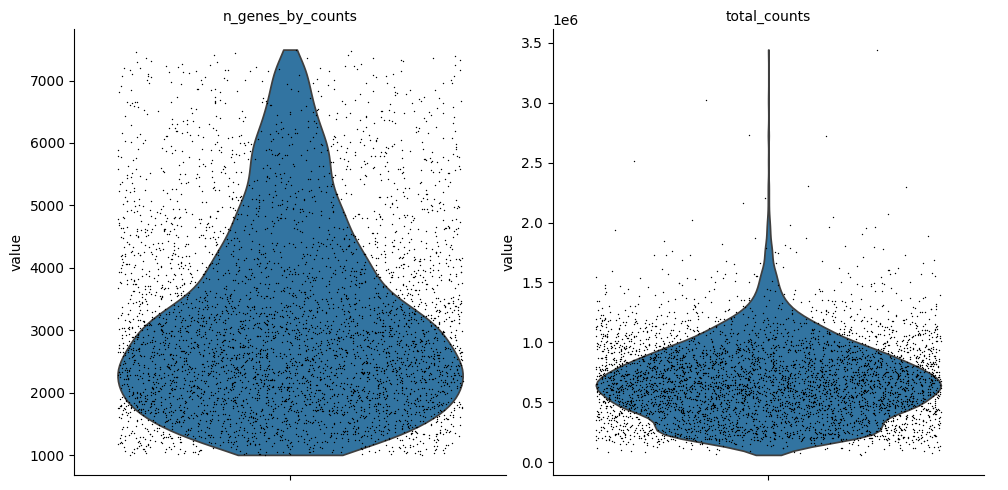

In [ ]:
sc.pl.violin(unfiltered,['n_genes_by_counts','total_counts'],jitter=0.4, multi_panel=True)

**4.Filter the cells further by slicing the anndata object on 'n_genes_by_counts' <6000 and 'total_counts' <1500000**

For n_genes_by_counts (remove cells with a high number of detected genes) this would be:
* data=data[data.obs.n_genes_by_counts <6000,:]


In [ ]:
hu=hu[hu.obs.n_genes_by_counts <6000,:]
hu=hu[hu.obs.total_counts <1500000,:]

**5.View the structure of the data after filtering steps**

In [ ]:
hu.obs

Patient   Author                       Tissue Disease_stage Age  \
CellID                                                                          
sc_b1_A08       33572  Hu_2020  Benign fallopian tube cells        Benign  64   
sc_b1_B06       34350  Hu_2020  Benign fallopian tube cells        Benign  50   
sc_b1_B08       34350  Hu_2020  Benign fallopian tube cells        Benign  50   
sc_b1_B11       34350  Hu_2020  Benign fallopian tube cells        Benign  50   
sc_b1_C15       34350  Hu_2020  Benign fallopian tube cells        Benign  50   
...               ...      ...                          ...           ...  ..   
15072R-p1-B17   15072  Hu_2020   HGSOC fallopian tube cells         IIIc1  62   
15072R-p1-B18   15072  Hu_2020   HGSOC fallopian tube cells         IIIc1  62   
15072R-p1-C01   15072  Hu_2020   HGSOC fallopian tube cells         IIIc1  62   
15072R-p1-C02   15072  Hu_2020   HGSOC fallopian tube cells         IIIc1  62   
15072R-p1-C03   15072  Hu_2020   HGSOC fallopian tube cells         IIIc1  62   

               n_genes  n_genes_by_counts  total_counts  \
CellID                                                    
sc_b1_A08         1326               1326      142098.0   
sc_b1_B06         1599               1599      273240.0   
sc_b1_B08         2298               2298      193108.0   
sc_b1_B11         2100               2100      195696.0   
sc_b1_C15         1793               1793      279434.0   
...                ...                ...           ...   
15072R-p1-B17     1640               1640     1097758.0   
15072R-p1-B18     1272               1272      845735.0   
15072R-p1-C01     2517               2517      497898.0   
15072R-p1-C02     2439               2439      284482.0   
15072R-p1-C03     3378               3377      232526.0   

               pct_counts_in_top_50_genes  pct_counts_in_top_100_genes  \
CellID                                                                   
sc_b1_A08                       24.091824                    36.650058   
sc_b1_B06                       25.742937                    34.621944   
sc_b1_B08                       24.946144                    32.246204   
sc_b1_B11                       20.842020                    29.207546   
sc_b1_C15                       19.775689                    27.739645   
...                                   ...                          ...   
15072R-p1-B17                   24.456210                    34.981754   
15072R-p1-B18                   20.502876                    31.127008   
15072R-p1-C01                   25.400584                    33.235522   
15072R-p1-C02                   24.317532                    32.932488   
15072R-p1-C03                   20.495773                    27.845058   

               pct_counts_in_top_200_genes  pct_counts_in_top_500_genes  
CellID                                                                   
sc_b1_A08                        55.252009                    86.714802  
sc_b1_B06                        47.672010                    74.232909  
sc_b1_B08                        42.474677                    62.877768  
sc_b1_B11                        41.628342                    66.753025  
sc_b1_C15                        39.917118                    66.523043  
...                                    ...                          ...  
15072R-p1-B17                    48.643872                    72.247435  
15072R-p1-B18                    46.902399                    78.237746  
15072R-p1-C01                    43.703730                    62.459781  
15072R-p1-C02                    44.442531                    63.933395  
15072R-p1-C03                    37.170897                    54.816666  

[4230 rows x 12 columns]

# **3.Dimensionality Reduction and visualisation**
To plot the data in a UMAP,


1. Initial pre-processing steps:
* Normalise the counts per cell, so each cell has 10,000 counts
* log transform the data

2.   Identify and crop the data to only the highly variable genes, then scale the data
3.   Compute the PCA
4.   Compute the Nearest neighbours graph
5.   Compute the UMAP




**1.Normalise and log transform the data**
* sc.pp.normalize_total(data, target_sum=1e4)
* sc.pp.log1p(data)

In [ ]:
sc.pp.normalize_total(hu, target_sum=1e4)
sc.pp.log1p(hu)

NameError: name 'sc' is not defined

**2.Crop the data to highly variable genes only**
* sc.pp.highly_variable_genes(data, min_mean=0.0125, max_mean=3, min_disp=0.5)
* sc.pl.highly_variable_genes(data)
* data.raw = data
* data = data [:, data.var.highly_variable]
* sc.pp.scale(data, max_value=10)

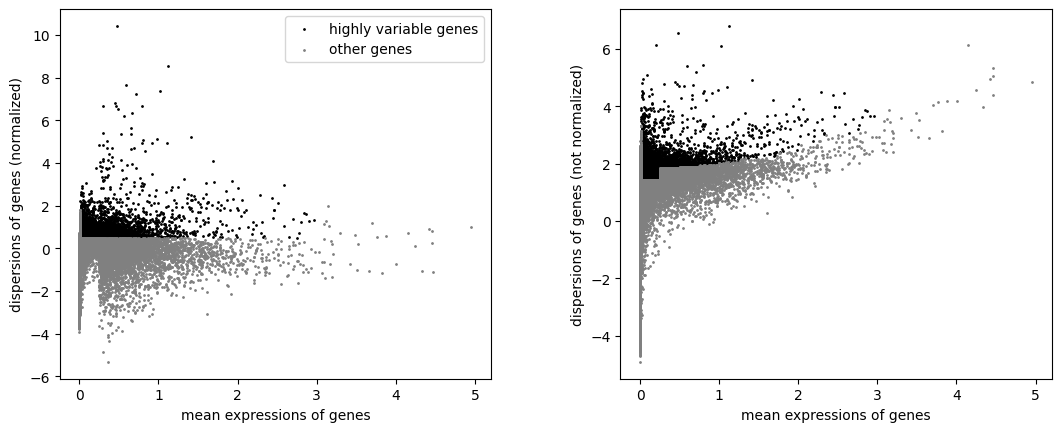

/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [ ]:
sc.pp.highly_variable_genes(hu, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(hu)
hu.raw = hu
hu = hu [:, hu.var.highly_variable]
sc.pp.scale(hu, max_value=10)

**3.Calculate and plot a principal component analysis (PCA) elbow plot**
* sc.tl.pca(data, svd_solver='arpack')
* sc.pl.pca_variance_ratio(data, log=True)
* sc.pl.pca(data, color=[' '])

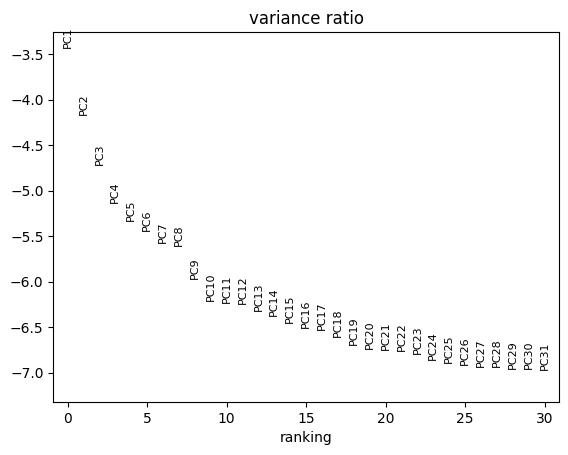

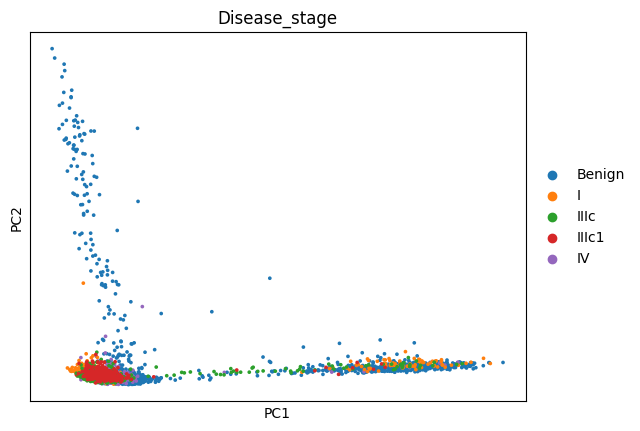

In [ ]:
sc.tl.pca(hu, svd_solver='arpack')
sc.pl.pca_variance_ratio(hu, log=True)

**4.Compute the nearest neighbours graph, choose the number of principal components to use based on the elbow of the PCA plot (inflection point)**
 * sc.pp.neighbors(data, n_pcs= )

In [ ]:
sc.pp.neighbors(hu, n_pcs=10)

In [ ]:
hu

AnnData object with n_obs × n_vars = 4230 × 721
    obs: 'Patient', 'Author', 'Tissue', 'Disease_stage', 'Age', 'n_genes', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'Disease_stage_colors', 'neighbors', 'umap', 'Tissue_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

**5.Compute and plot the UMAP**
* sc.tl.umap(data)

Plot the UMAP by Tissue, or another value of.obs columns
* sc.pl.umap(data, color=[''])


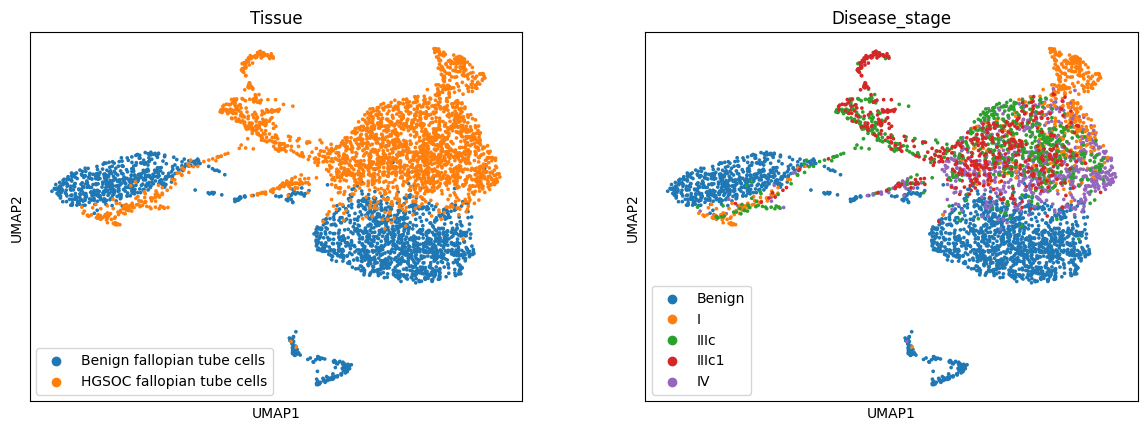

In [ ]:
sc.tl.umap(hu)
sc.pl.umap(hu, color=['Tissue','Disease_stage'], legend_loc='lower left' )


Plot the UMAP in the color of gene expression (use one of the genes from top 20 highly expressed genes)

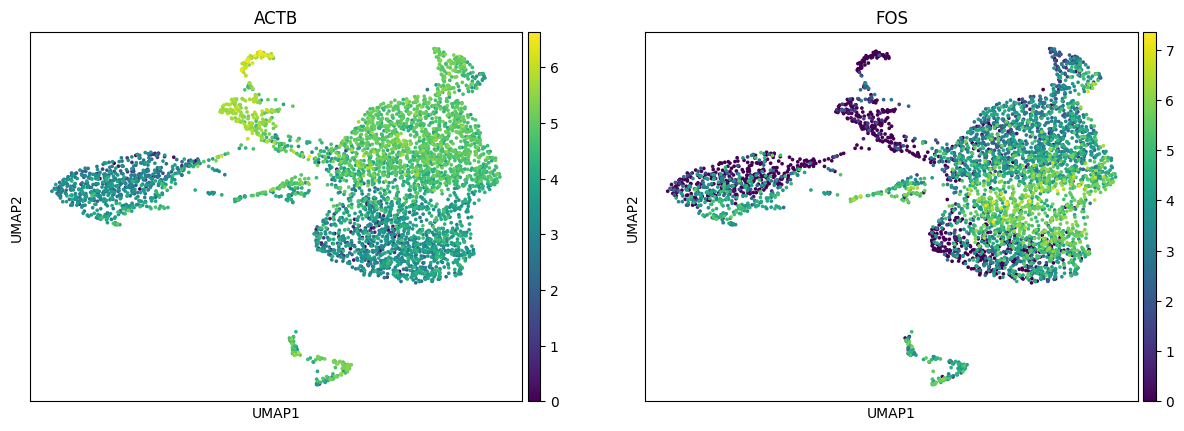

In [ ]:
sc.tl.umap(hu)
sc.pl.umap(hu,color=['ACTB', 'FOS'])

**6.Examine how the UMAP structure changes when you change the number of pcs used to generate the n_neighbours graph**

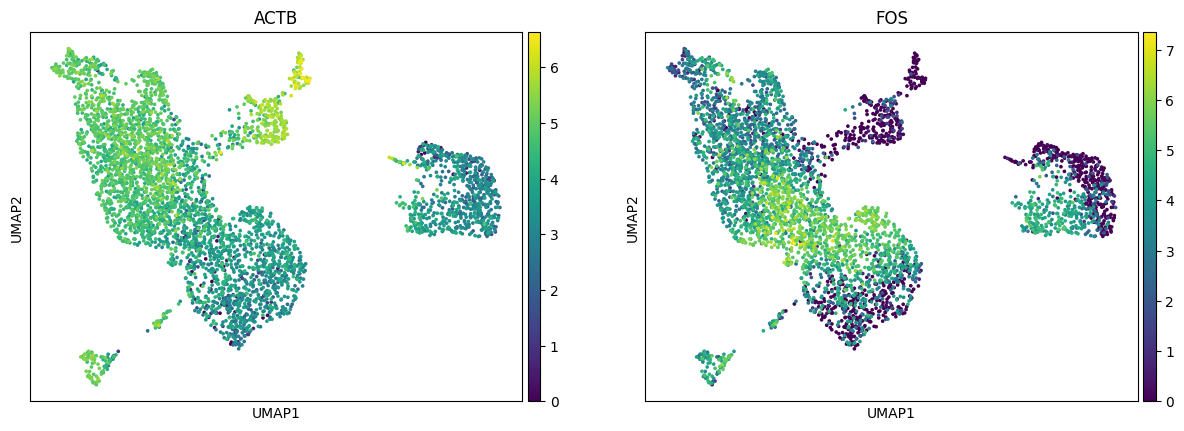

In [ ]:
sc.pp.neighbors(hu, n_pcs=9)
sc.tl.umap(hu)
sc.pl.umap(hu,color=['ACTB', 'FOS'])

**7. Re-run the nearest neighbours graph and UMAP with optimal number of PCs**

# **5.Leiden clustering**
Cluster the cells to identify similar groups of cells
* By examining gene expression, determine what type of cells are in each cluster
* Using a dictionary, create a new obs. column assigning a label of cell type to leiden clusters
* Test the top differentially expressed genes in each leiden cluster/cell type
* Plot a heatmap of top differentially expressed genes in each leiden cluster/cell type

**1. Perform leiden clustering, then visualise clusters on the UMAP**
* sc.tl.leiden(data, resolution=0.2)
* sc.pl.umap(data, colour=['Leiden'])

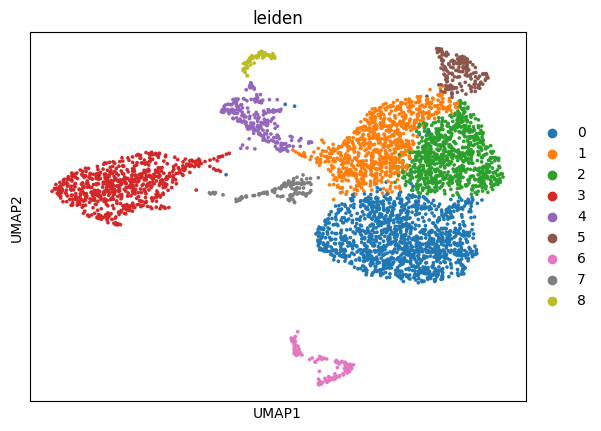

In [ ]:
sc.tl.leiden(hu, resolution=0.3)
sc.pl.umap(hu, color=['leiden'])

**2. Calculate the top differentially expressed genes in each leiden cluster**
* sc.tl.rank_genes_groups(data,'leiden', method='wilcoxon')
* sc.pl.rank_genes_groups(data, n_genes=25)

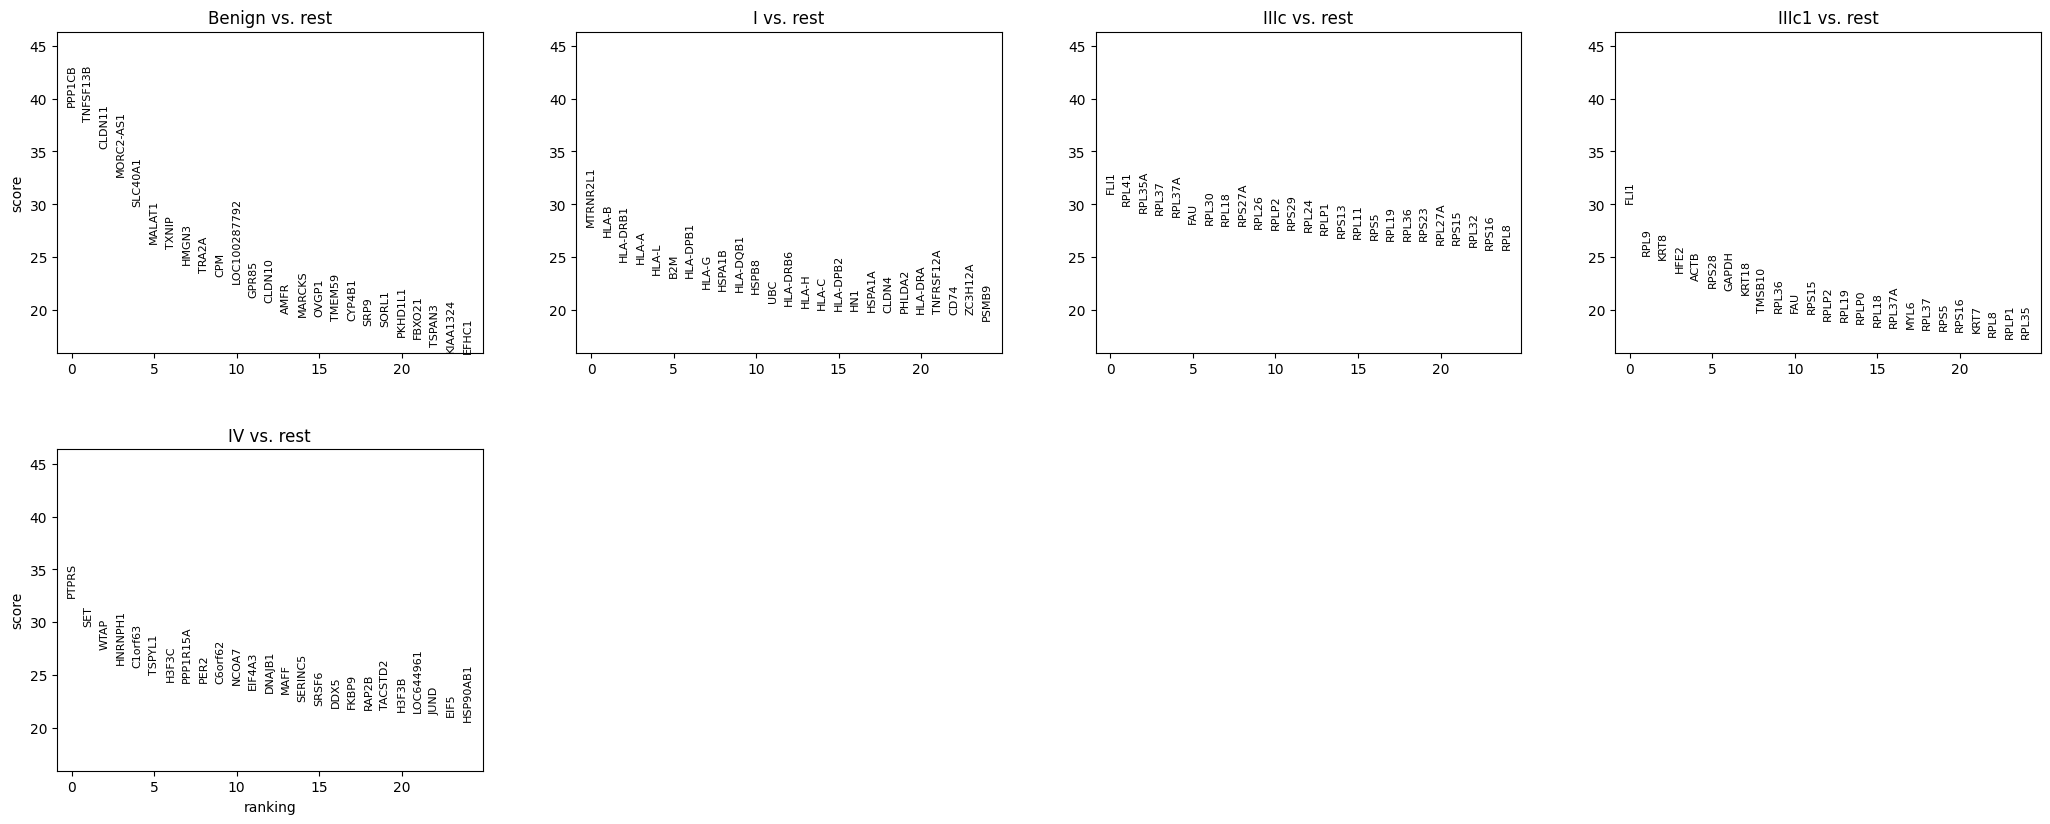

In [ ]:
sc.tl.rank_genes_groups(hu,'Disease_stage', method='wilcoxon')
sc.pl.rank_genes_groups(hu, n_genes=25)

**3. Export the ranked genes, with scores to a csv file (we will come back to these tomorrow)**

In [ ]:
topmarkers=hu.uns['rank_genes_groups']
groups = topmarkers['names'].dtype.names
celltypemarkergenes = pd.DataFrame({group +'_'+key[:1]:topmarkers[key][group]
              for group in groups for key in ['names','scores']})

celltypemarkergenes.to_csv(r'diseasestagemarkergenes.csv', index=False)

celltypemarkergenes

Benign_n   Benign_s       I_n        I_s    IIIc_n     IIIc_s  \
0         PPP1CB  39.337444  MTRNR2L1  27.957920      FLI1  31.019861   
1       TNFSF13B  37.879189     HLA-B  26.942499     RPL41  29.937895   
2         CLDN11  35.353798  HLA-DRB1  24.644037    RPL35A  29.227337   
3      MORC2-AS1  32.688828     HLA-A  24.378878     RPL37  29.026594   
4        SLC40A1  29.813505     HLA-L  23.373926    RPL37A  28.851164   
...          ...        ...       ...        ...       ...        ...   
20367      RPS29 -41.504112     OVGP1  -8.290361      PAN3 -17.493778   
20368       KRT8 -42.709927    PPP1CB  -9.037016  MTRNR2L1 -18.101784   
20369       ACTB -42.760891   SCGB1D2  -9.375245     HLA-H -19.767263   
20370      ACTG1 -43.826477    CLDN11 -11.088444     HLA-L -21.720694   
20371        FAU -46.776478  TNFSF13B -13.405902     HLA-G -27.808664   

        IIIc1_n    IIIc1_s       IV_n       IV_s  
0          FLI1  30.076841      PTPRS  32.335445  
1          RPL9  25.208969        SET  29.564119  
2          KRT8  24.754698       WTAP  27.462831  
3          HFE2  23.536341    HNRNPH1  26.044836  
4          ACTB  22.834707    C1orf63  25.701227  
...         ...        ...        ...        ...  
20367     TRA2A -17.504068     IGFBP7 -15.137327  
20368  MTRNR2L1 -18.127424    SLC40A1 -15.668846  
20369   SERINC5 -18.343018  MORC2-AS1 -18.295168  
20370    PPP1CB -22.173014     CLDN11 -22.674721  
20371    MALAT1 -24.773638   TNFSF13B -25.044207  

[20372 rows x 10 columns]

**3. Plot top 20 differentially expressed genes in a heatmap**

* sc.pl.rank_genes_groups_heatmap(data, n_genes=20, swap_axes=True, show_gene_labels=False, vmin=-3, vmax=3 )

categories: 0, 1, 2, etc.
var_group_labels: 0, 1, 2, etc.


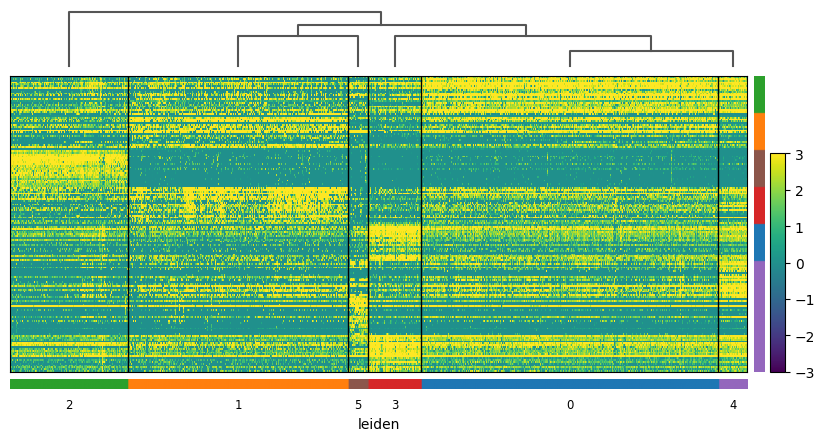

In [ ]:
sc.pl.rank_genes_groups_heatmap(hu, n_genes=20, swap_axes=True, show_gene_labels=False, vmin=-3, vmax=3 )

**4. Visualise marker genes to determine the cell types present in each cluster**

Secretory Epithelial : OVGP1

Ciliated Epithelial : FOXJ1, PIFO

Immune: PTPRC

Fibroblast: COL1A1, DCN

STIC lesion : KRT17


* sc.pl.violin(data, ['EPCAM','OVGP1','...'], groupby = 'leiden')


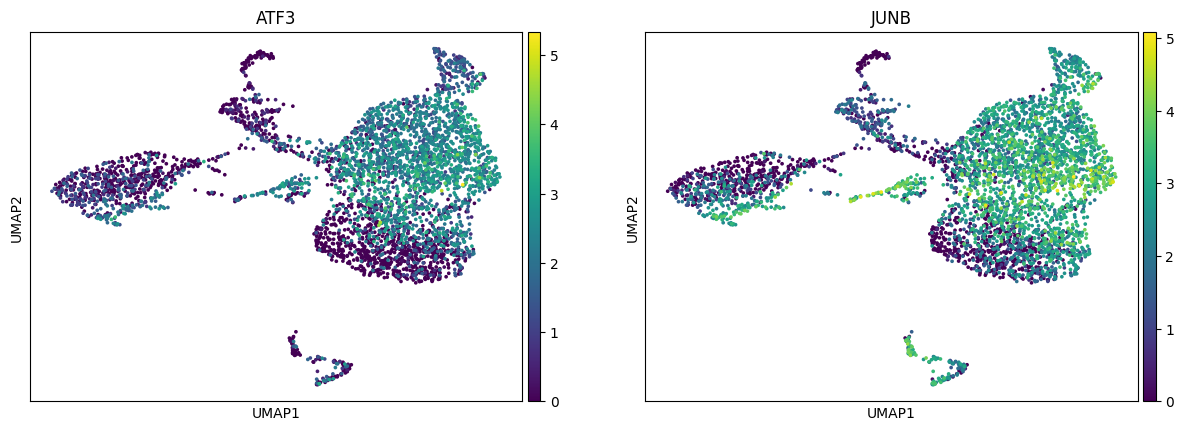

In [ ]:
sc.pl.umap(hu, color=['ATF3', 'JUNB'])

**5. From these markers, it is still unclear what cell types some of the leiden clusters are**

Look up some of the top marker genes for these clusters to determine what cell types they are.

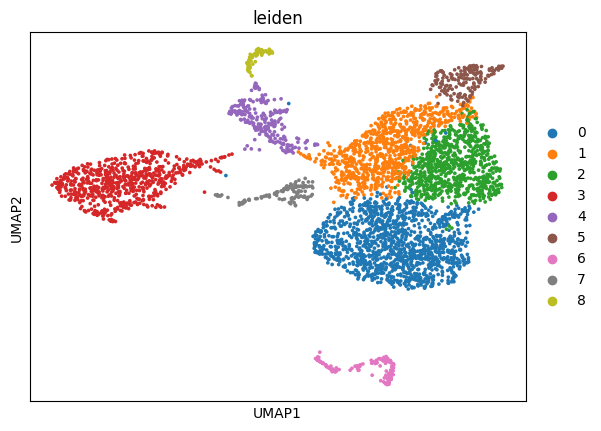

In [ ]:
sc.pl.umap(hu, color=['leiden'])

**6. Create a dictionary defining Leiden clusters and their respective cell type**

Create a new .obs column to store the cell types , and map this to leiden clusters using the dictionary,

Which cluster represents high grade carcinoma cells?

```
celltypedict = {
        '0' : 'Secretory Epithelial',
        '1' : 'Fibroblast' }

data.obs['Celltype'] = hu.obs['leiden'].map(celltypedict)


In [ ]:
celltypedict = {
        '0' : 'Secretory Epithelial-1',
        '1' : 'Secretory Epithelial-2',
        '2' : 'Secretory Epithelial-2',
        '3' : 'Ciliated Epithelial',
        '4' : 'High grade Carcinoma',
        '5' : 'STIC lesion',
        '6' : 'Immune',
        '7' : 'Fibroblast',
        '8' : 'STIC lesion'}
hu.obs['Celltype'] = hu.obs['leiden'].map(celltypedict)

**7. Plot a UMAP colored by cell types**

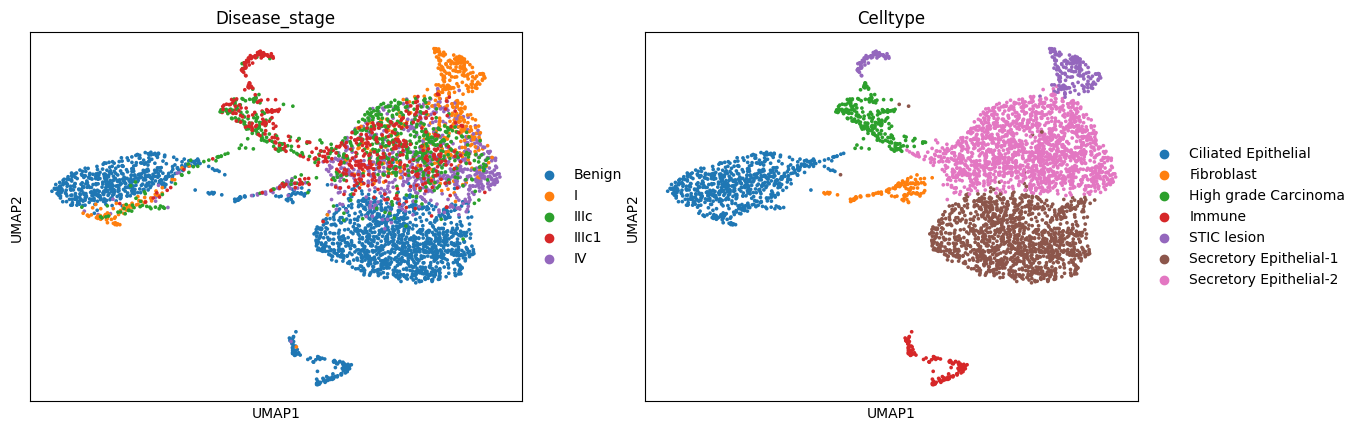

In [ ]:
sc.pl.umap(hu, color=['Disease_stage','Celltype',])

## **6. Querying GWAS catalog API**


As these women were diagnosed with ovarian cancers, we can use the GWAS catalog to look at the expression of genes associated with epithelial carcinomas

Use the packages: 'requests' and 'json'

Make a get request to the API for the association data from study no. GCST003588, the https address to use is "https://www.ebi.ac.uk/gwas/rest/api/studies/GCST003588/associations"





**3. We can use the GWAS catalog obtain a list of genes associated with high grade serous ovarian carcinoma**


In [ ]:
import requests
import json

In [ ]:
response=requests.get("https://www.ebi.ac.uk/gwas/rest/api/studies/GCST003588/associations")
response.json()



JSONDecodeError: Expecting value: line 1 column 1 (char 0)

**4.Make a Pandas dataframe containing 'riskAlleleName' and 'geneName'**
* If you don't know how to do this, solution is in the 'geneIdsjson.py' file in the Github repository

In [ ]:
associations_data = response.json()['_embedded']['associations']
gwas = pd.json_normalize(associations_data, 'loci')
risk_alleles = gwas.explode('strongestRiskAlleles').explode('authorReportedGenes').reset_index(drop=True)
risk_alleles_df = pd.json_normalize(risk_alleles['strongestRiskAlleles'])
reportedgenes_df = pd.json_normalize(risk_alleles['authorReportedGenes'])
gwasgenes=pd.concat([risk_alleles_df, reportedgenes_df], axis=1)
gwasgenes = gwasgenes[['riskAlleleName', 'geneName']]
gwasgenes

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

**5. To plot the gene expression of carcinoma GWAS genes, convert this to a list**
* genes=[gene for gene in gwasgenes['geneName'].tolist() if gene !='Intergenic']

In [ ]:
gwas_genes = ['NEK10', 'CDKN2B', 'FRY', 'FGFR2', 'SH2B3', 'BRCA2']

In [ ]:
hu

AnnData object with n_obs × n_vars = 4230 × 5851
    obs: 'Patient', 'Author', 'Tissue', 'Disease_stage', 'Age', 'n_genes', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'leiden', 'Celltype'
    var: 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'Disease_stage_colors', 'neighbors', 'leiden', 'umap', 'Tissue_colors', 'leiden_colors', 'Celltype_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

**6. Plot gene expression of Carcinoma GWAS genes per leiden cluster in a dot plot**
* sc.pl.dotplot()


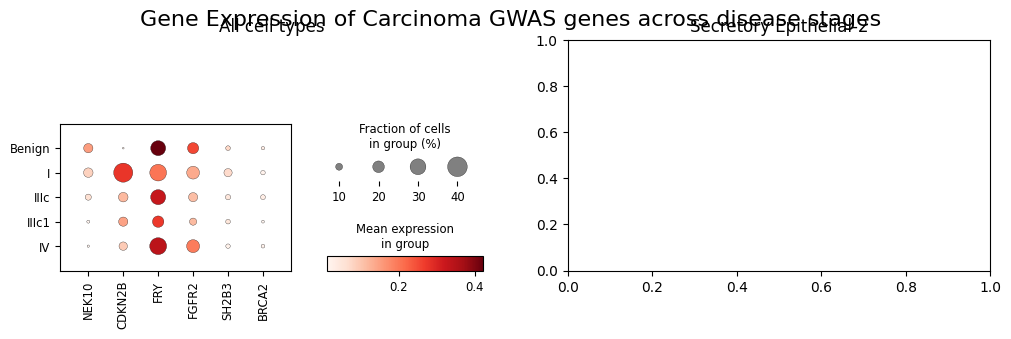

In [ ]:
SE2=hu[hu.obs.Celltype=='Secretory Epithelial-2',:]

ncols = 2
nrows = 1
figsize = 3
wspace = 1
fig, axs = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(ncols * figsize + figsize * wspace * ncols, nrows * figsize),
)


fig.suptitle("Gene Expression of Carcinoma GWAS genes across disease stages", fontsize=16)

axs[0].title.set_text('All cell types')
axs[1].title.set_text('Secretory Epithelial-2')

sc.pl.dotplot(hu, gwas_genes , groupby='Disease_stage',ax=axs[0],)
sc.pl.dotplot(SE2, gwas_genes , groupby='Disease_stage',ax=axs[1],)


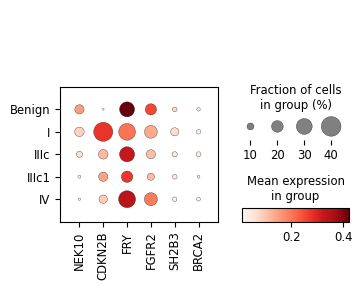

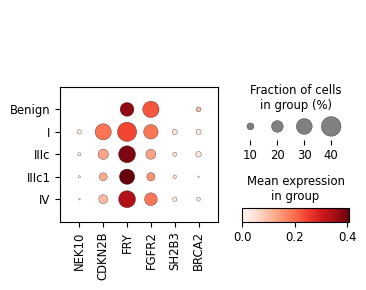

In [ ]:
sc.pl.dotplot(hu, gwas_genes , groupby='Disease_stage')
sc.pl.dotplot(SE2, gwas_genes , groupby='Disease_stage')

**7. Plot gene expression of the highly expressed carcinoma GWAS genes in a UMAP, compare this to a UMAP of Disease Stage**

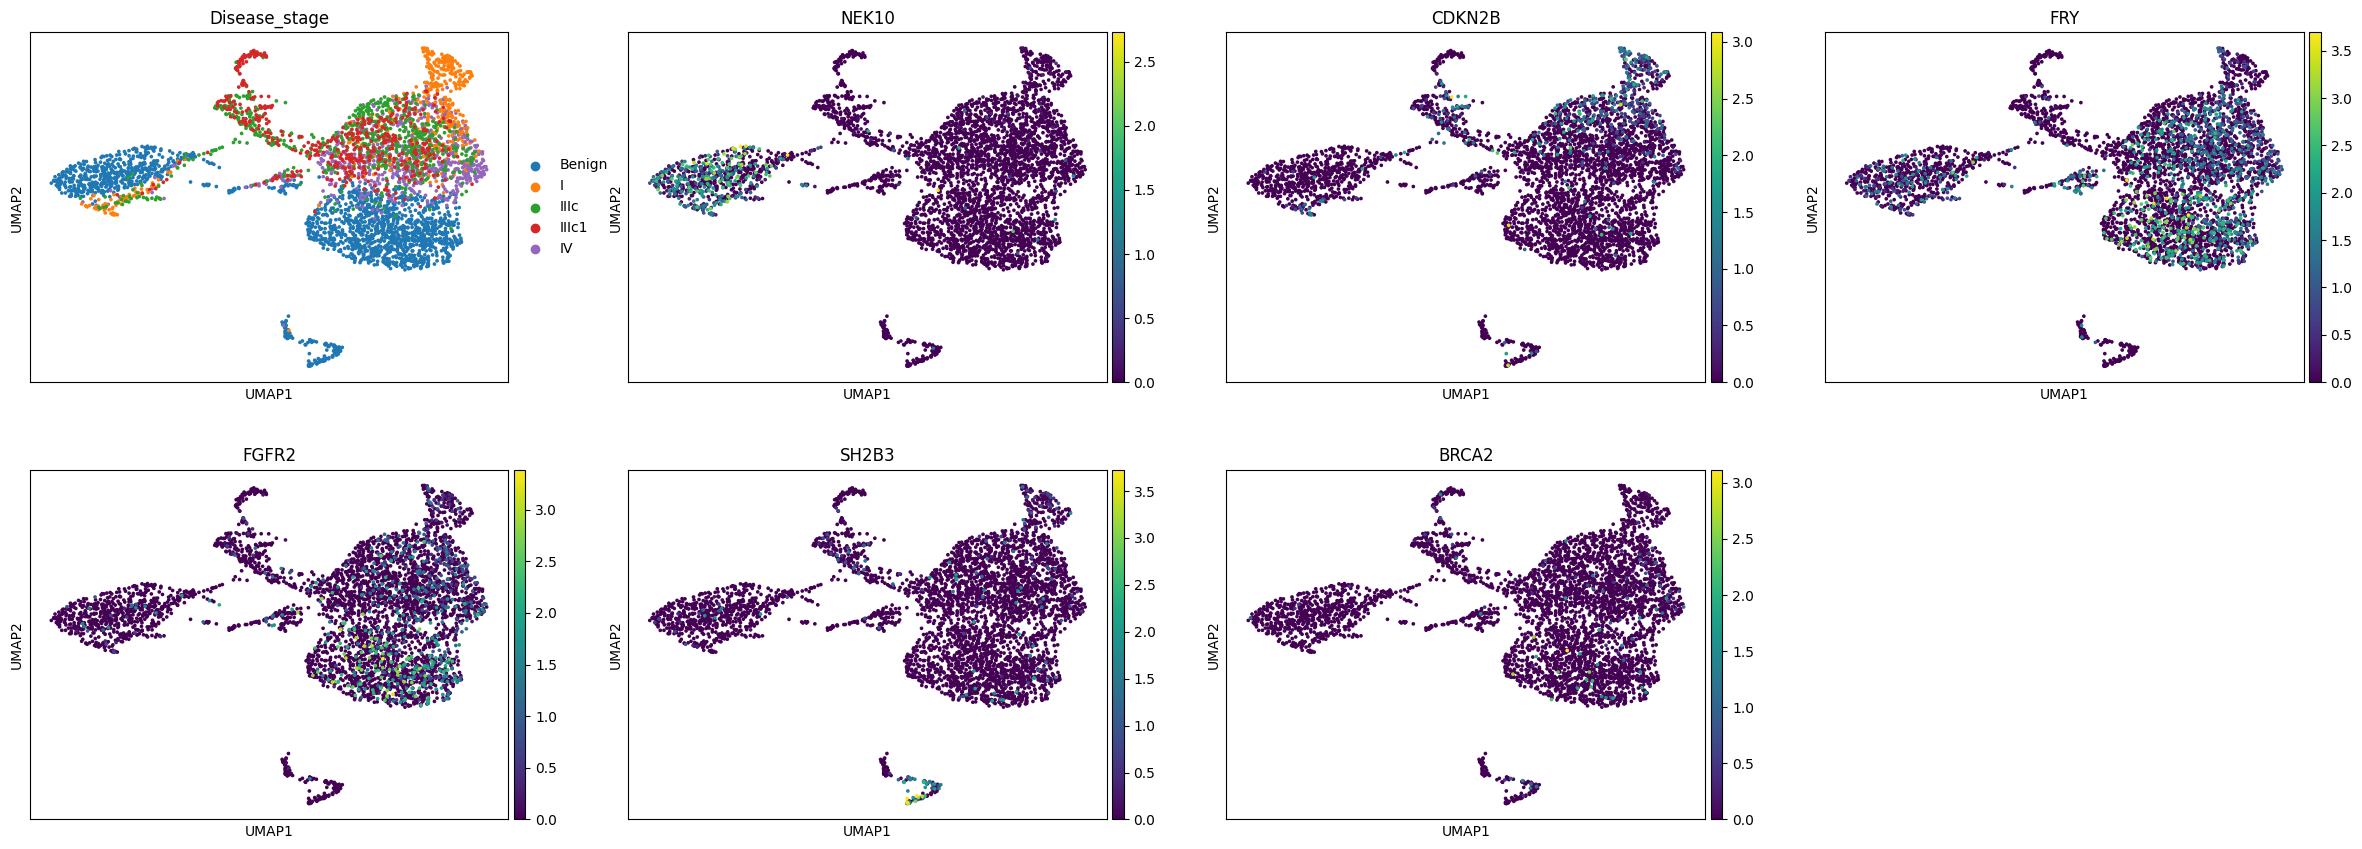

In [ ]:
sc.pl.umap(hu, color=['Disease_stage', 'NEK10', 'CDKN2B', 'FRY', 'FGFR2', 'SH2B3', 'BRCA2'])

## **6. Subsetting secretory epithelial cells**
As HGOC is thought to originate from epithelial cells in the fallopian tube, we can examine epithelial cells in greater depth by creating a subset of the data of epithelial cells.

**1. Create new object of a subset of epithelial cell data**
* subset = data[data.obs['Celltype'].isin([''])]

In [ ]:
secretory = hu[hu.obs['Celltype'].isin(['Secretory Epithelial-1','Secretory Epithelial-2','STIC lesion'])]

**2. Run the dimensionality reduction and clustering analysis again to identify clusters of epitheilal cells**

/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca


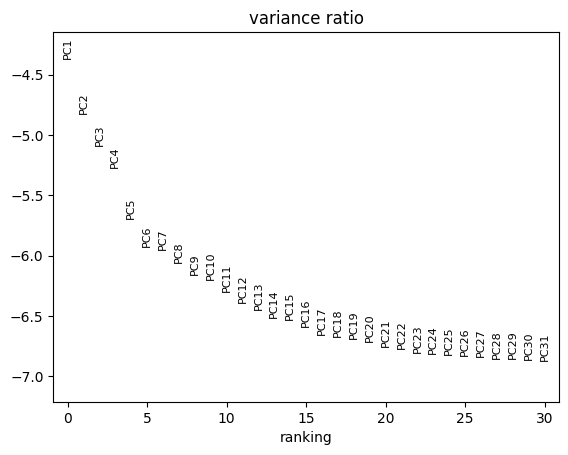

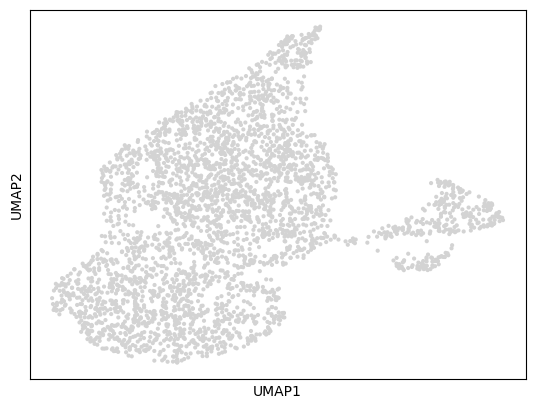

In [ ]:
secretory
sc.tl.pca(secretory)
sc.pl.pca_variance_ratio(secretory, log=True)
sc.pp.neighbors(secretory, n_pcs=4)
sc.tl.umap(secretory)
sc.pl.umap(secretory)

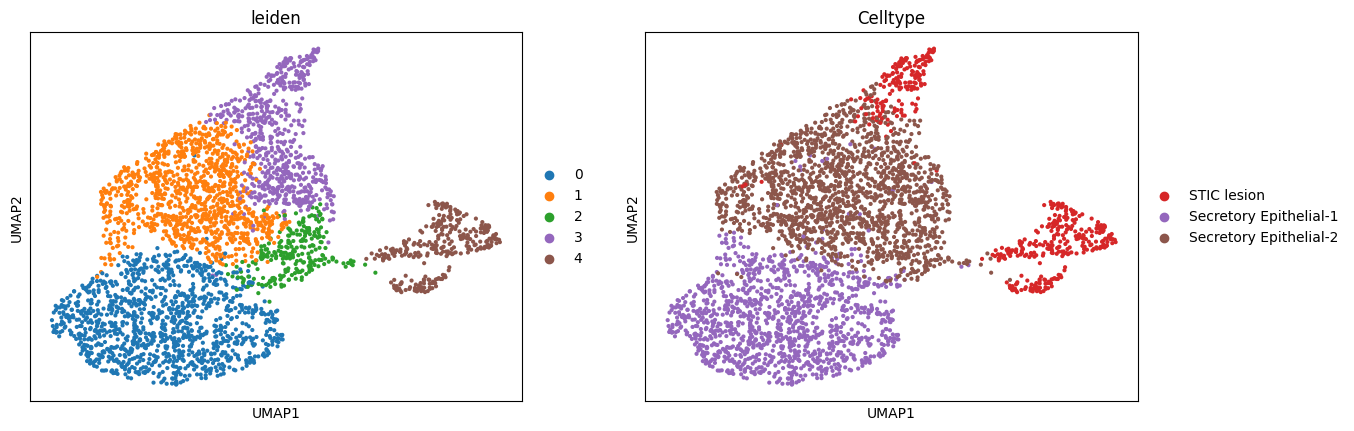

In [ ]:

sc.tl.leiden(secretory, resolution=0.2,flavor="igraph")
sc.pl.umap(secretory, color=['leiden','Celltype'])


In [ ]:

pd.DataFrame(secretory.uns["rank_genes_groups"]["names"]).head(25)

0         1         2         3          4         5        6  \
0      CRISP3   TACSTD2      MAFF   FAM183A       ENO1  HLA-DQA1     SRGN   
1      FBXO21      SOD2      ATF3  C20orf85      HMGA1  HLA-DPB1   TMSB4X   
2       OVGP1      EIF1  PPP1R15A  C1orf194      ANXA2  HLA-DRB1   LAPTM5   
3     SLC40A1     ACTG1   SERTAD1     TPPP3    S100A10     HLA-B      B2M   
4      CLDN10       FAU    DNAJB1      CAPS  TNFRSF12A        HP     RGS1   
5         CLU    NFKBIA      CKS2      PIFO       PFN1  HLA-DPB2    PTPRC   
6      PPP1CB      DDX5     NCOA7      SNTN     TXNRD1     WFDC2  ARHGDIB   
7         GSN     RPS27     CLDN4      AGR3       GARS       C1R     CD53   
8     SPARCL1      MAFF   TACSTD2     CDHR3       EMP3  HLA-DRB6    ITGB2   
9      CLDN11   SERTAD1     CYR61     RSPH1        RAN      PAEP      FYB   
10    PKHD1L1    DNAJA1      DDX5    MS4A8B     MYL12A  HLA-DPA1  ALOX5AP   
11   TNFSF13B   ZC3H12A     RPS27     CETN2       WDR1      CD74    HLA-B   
12      SORL1  PPP1R15A     RPL31     CAPSL       KRT7      SLPI   S100A4   
13     ARGLU1  HSP90AB1   TSC22D2   C9orf24       MARS    CHI3L1  TSC22D3   
14    ZFP36L1     RPS19     RPS14     TEKT1    S100A11     HLA-A    HLA-H   
15       INSR      KRT8     RPL34   DYNLRB2     S100A6   RARRES1   TYROBP   
16     MALAT1     NR4A1     RPS19   FAM216B        SFN    IFITM1   STK17B   
17     ASRGL1     RPS14   ZC3H12A     MORN5    S100A16  HLA-DQB1     LCP1   
18  MORC2-AS1     CXCL2   C1orf63   ZMYND10     DDX39A   HLA-DRA    CXCR4   
19      MEIS1    DNAJB1    EIF4A3  C1orf192      PSMA7      LCN2   FCER1G   
20       EMX2      RND3      IRF1      AGR2     MYL12B     HLA-C    HCLS1   
21        ID4     HBEGF     ACTG1  C11orf88      CLIC1       C1S     AIF1   
22    SCGB1D2     NCOA7      EIF1    PSENEN      CDCP1    IFITM3     BTG1   
23       TOB1     H2AFZ      FOSB       AK1      ANXA5     HLA-L     CYBB   
24        WT1       UBC    CSRNP1    DNAH12     SLC1A5       B2M    MS4A7   

           7         8  
0      TIMP3     GAPDH  
1        UBB    TMSB10  
2      SPARC      CFL1  
3     LGALS1    LGALS1  
4     IGFBP5     ANXA2  
5        DCN      KRT7  
6      CALD1     GSTP1  
7    SPARCL1     ARPC2  
8      HSPB6   S100A11  
9      ACTA2      PFN1  
10  CRISPLD2    S100A6  
11     ADIRF      ACTB  
12    COL1A1    CHCHD2  
13       MGP     HMGA1  
14      TPM2   S100A10  
15     GNG11  C12orf75  
16      SELM      RHOC  
17       FTL  SH3BGRL3  
18     MFAP4      GUK1  
19       C1S       PKM  
20   GADD45B     ANXA3  
21      MYL9      ENO1  
22       ID2     MFAP5  
23      EBF1   S100A16  
24    EFEMP1      KRT8